# Light curves

## Introduction

This tutorial explain how to compute a light curve with Gammapy.

We will use the four Crab nebula observations from the [H.E.S.S. first public test data release](https://www.mpi-hd.mpg.de/hfm/HESS/pages/dl3-dr1/) and compute per-observation fluxes. The Crab nebula is not known to be variable at TeV energies, so we expect constant brightness within statistical and systematic errors.

The main classes we will use are:

* [gammapy.time.LightCurve](http://docs.gammapy.org/dev/api/gammapy.time.LightCurve.html)
* [gammapy.time.LightCurveEstimator](http://docs.gammapy.org/dev/api/gammapy.time.LightCurveEstimator.html)

## Setup

As usual, we'll start with some setup...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.utils.energy import EnergyBounds
from gammapy.data import DataStore
from gammapy.spectrum import SpectrumExtraction
from gammapy.spectrum.models import PowerLaw
from gammapy.background import ReflectedRegionsBackgroundEstimator
from gammapy.time import LightCurve, LightCurveEstimator

## Spectrum

The `LightCurveEstimator` is based on a 1d spectral analysis within each time bin.
So before we can make the light curve, we have to extract 1d spectra.

In [2]:
data_store = DataStore.from_dir("../datasets/hess-dl3-dr1/")

In [3]:
mask = data_store.obs_table['OBS_SUBSET_TAG'] == 'crab'
obs_ids = data_store.obs_table['OBS_ID'][mask].data
observations = data_store.obs_list(obs_ids)
print(observations)

ObservationList
Number of observations: 4
Info for OBS_ID = 23523
- Start time: 53343.92
- Pointing pos: RA 83.63 deg / Dec 21.51 deg
- Observation duration: 1687.0 s
- Dead-time fraction: 6.240 %
Info for OBS_ID = 23526
- Start time: 53343.95
- Pointing pos: RA 83.63 deg / Dec 22.51 deg
- Observation duration: 1683.0 s
- Dead-time fraction: 6.555 %
Info for OBS_ID = 23559
- Start time: 53345.96
- Pointing pos: RA 85.25 deg / Dec 22.01 deg
- Observation duration: 1686.0 s
- Dead-time fraction: 6.398 %
Info for OBS_ID = 23592
- Start time: 53347.91
- Pointing pos: RA 82.01 deg / Dec 22.01 deg
- Observation duration: 1686.0 s
- Dead-time fraction: 6.212 %



In [4]:
# Target definition
target_position = SkyCoord(ra=83.63308, dec=22.01450, unit="deg")
on_region_radius = Angle("0.2 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

In [5]:
%%time
bkg_estimator = ReflectedRegionsBackgroundEstimator(
    on_region=on_region, obs_list=observations
)
bkg_estimator.run()

CPU times: user 1.73 s, sys: 17.8 ms, total: 1.75 s
Wall time: 1.75 s


In [8]:
%%time
ebounds = EnergyBounds.equal_log_spacing(0.7, 100, 50, unit="TeV")
extraction = SpectrumExtraction(
    obs_list=observations,
    bkg_estimate=bkg_estimator.result,
    containment_correction=False,
    e_reco=ebounds,
    e_true=ebounds,
)
extraction.run()
spectrum_observations = extraction.observations

CPU times: user 814 ms, sys: 6.46 ms, total: 820 ms
Wall time: 820 ms


## Light curve estimation

OK, so now that we have prepared 1D spectra (not spectral models, just the 1D counts and exposure and 2D energy dispersion matrix), we can compute a lightcurve.

To compute the light curve, a spectral model shape has to be assumed, and an energy band chosen.
The method is then to adjust the amplitude parameter of the spectral model in each time bin to the data, resulting in a flux measurement in each time bin.

In [13]:
# Creat list of time bin intervals
# Here we do one time bin per observation
def time_intervals_per_obs(observations):
    for obs in observations:
        yield obs.tstart, obs.tstop
        
time_intervals = list(time_intervals_per_obs(observations))

In [16]:
# Assumed spectral model
spectral_model = PowerLaw(
    index=2,
    amplitude=2.e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)

In [18]:
energy_range=[1, 100] * u.TeV

In [19]:
%%time
lc_estimator = LightCurveEstimator(extraction)
lc = lc_estimator.light_curve(
    time_intervals=time_intervals,
    spectral_model=spectral_model,
    energy_range=energy_range,
)

CPU times: user 1.41 s, sys: 57.2 ms, total: 1.47 s
Wall time: 1.51 s


## Results

The light curve measurement result is stored in a table. Let's have a look at the results:

In [21]:
print(lc.table.colnames)

['time_min', 'time_max', 'flux', 'flux_err', 'flux_ul', 'is_ul', 'livetime', 'n_on', 'n_off', 'alpha', 'measured_excess', 'expected_excess']


In [23]:
lc.table[
    "time_min",
    "time_max",
    "flux",
    "flux_err",
]

time_min,time_max,flux,flux_err
,,1 / (cm2 s),1 / (cm2 s)
float64,float64,float64,float64
53343.92234009259,53343.94186555556,1.839834552434914e-11,1.8993229068363982e-12
53343.95421509259,53343.97369425926,1.9975853809663366e-11,2.0202859435674313e-12
53345.96198129629,53345.98149518518,2.193293401955398e-11,2.5526997556899865e-12
53347.913196574074,53347.93271046296,2.3179879073655363e-11,2.5670181770343347e-12


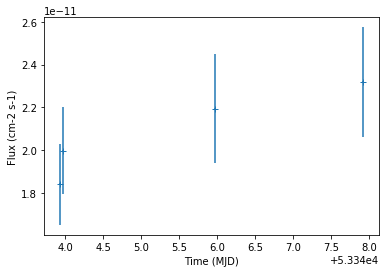

In [25]:
lc.plot();

In [31]:
# Let's compare to the expected flux of this source
from gammapy.spectrum import CrabSpectrum
crab_spec = CrabSpectrum().model
crab_flux = crab_spec.integral(*energy_range).to('cm-2 s-1')
crab_flux

<Quantity 2.07401493e-11 1 / (cm2 s)>

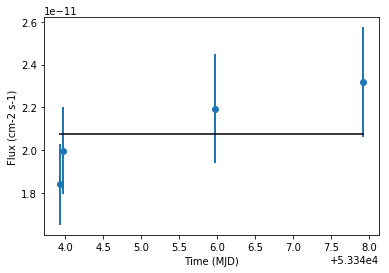

In [41]:
ax = lc.plot(marker='o', lw=2)
ax.hlines(crab_flux.value, xmin=lc.table['time_min'].min(), xmax=lc.table['time_max'].max());

## Exercises

* Change the assumed spectral model shape (e.g. to a steeper power-law), and see how the integral flux estimate for the lightcurve changes.
* Try a time binning where you split the observation time for every run into two time bins.
* Try to analyse the PKS 2155 flare data from the H.E.S.S. first public test data release.
  Start with per-observation fluxes, and then try fluxes within 5 minute time bins for one or two of the observations where the source was very bright.